# POS tagging using modified Viterbi - Assignment

### Data Preparation

In [2]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [3]:
# reading the Treebank tagged sentences with universal tagset
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
#First three sentences in te dataset
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

__Splitting Data into Training & Test__

In [5]:
#set the random seed
random.seed(1234)

#Divide the data into training and test sets
train_set, test_set = train_test_split(nltk_data,train_size=0.95)

#Get the length of training and test sets
print(len(train_set))
print(len(test_set))

3718
196


c:\python3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
train_tagged_words = [tup for sent in train_set for tup in sent]
#Length of the total tagged words in the training set
len(train_tagged_words)

# test_tagged_words = [tup for sent in test_set for tup in sent]
# len(test_tagged_words)

95678

In [7]:
#Sample tokens from the overall set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Old', 'Spaghetti', 'Warehouse', 'rose', '1', 'to', '16', '1\\/8', '.', 'The']

In [8]:
# Total unique words in the training set
V = set(tokens)
print(len(V))

12083


In [9]:
# Count of POS tags in the training set
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'VERB', 'ADJ', '.', 'CONJ', 'NUM', 'PRT', 'X', 'ADV', 'DET', 'ADP', 'PRON', 'NOUN'}


The number of tags in the universal tagset is 12

### Build the vanilla Viterbi based POS tagger

In [10]:
#Creation of array between POS tags & Vocabulary for computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t (pos tags x pos tags)transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,VERB,ADJ,.,CONJ,NUM,PRT,X,ADV,DET,ADP,PRON,NOUN
VERB,0.168537,0.065542,0.034899,0.005417,0.023214,0.031494,0.217132,0.081328,0.134179,0.092239,0.035441,0.110578
ADJ,0.012171,0.067763,0.064474,0.016941,0.020888,0.011020,0.021382,0.004770,0.004770,0.078454,0.000658,0.696711
.,0.089991,0.044274,0.093508,0.057980,0.080343,0.002344,0.027142,0.052750,0.175383,0.091253,0.066817,0.218124
CONJ,0.157723,0.112926,0.035464,0.000467,0.041064,0.005133,0.008399,0.053196,0.121792,0.051797,0.060663,0.351377
NUM,0.018419,0.033868,0.117053,0.013666,0.185086,0.027629,0.207071,0.002674,0.003268,0.034462,0.001485,0.355318
PRT,0.401562,0.085584,0.043280,0.002278,0.057598,0.001627,0.013993,0.009112,0.100879,0.020827,0.018223,0.245037
X,0.204585,0.016717,0.163509,0.009712,0.002866,0.186117,0.074829,0.026588,0.053495,0.146155,0.055087,0.060341
ADV,0.344862,0.129365,0.136349,0.007316,0.031926,0.014300,0.021949,0.079814,0.070170,0.117060,0.014633,0.032258
DET,0.041084,0.203976,0.017229,0.000482,0.022169,0.000241,0.045904,0.012651,0.004940,0.009518,0.003253,0.638554
ADP,0.008407,0.106843,0.039694,0.000958,0.061828,0.001490,0.034798,0.013728,0.323720,0.016920,0.069277,0.322337


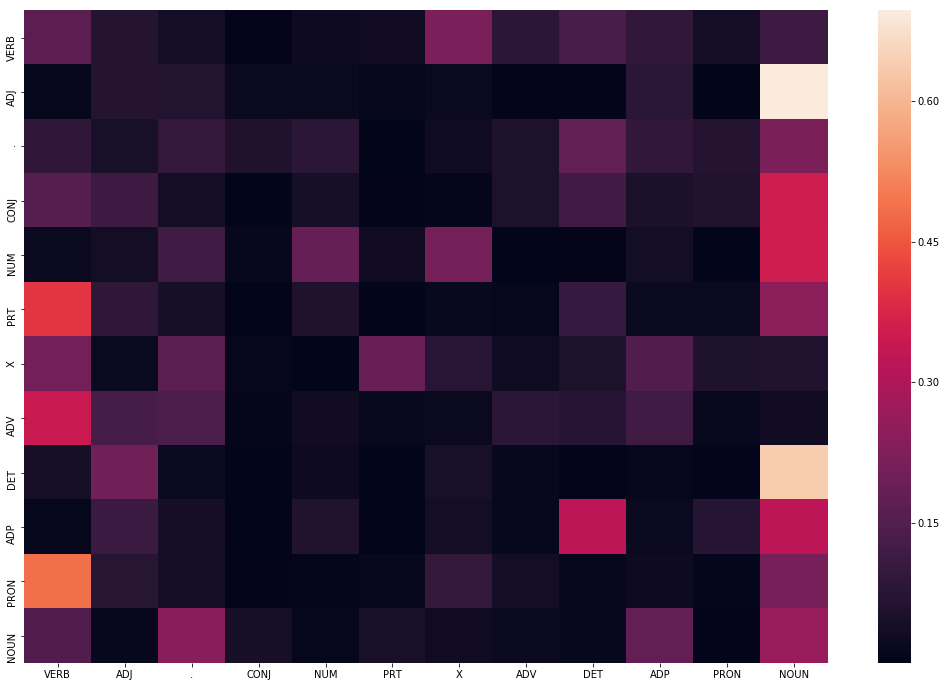

In [15]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

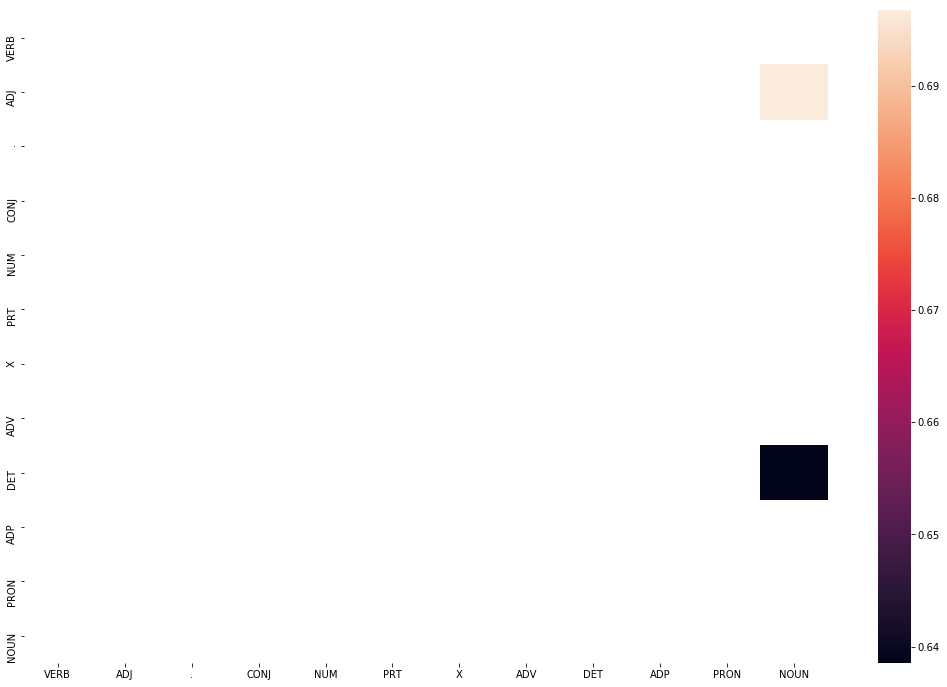

In [16]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

As per the matrix it's observed that the Noun tag is highly correlated with Adjective and Determinent. It is also particular that many a times nouns are followed by adjectives and detectives

In [17]:
#Get the total length of tagged words in training corpus
len(train_tagged_words)

95678

In [18]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
# list of tagged words in test set
test_run_base = [tup for sent in test_set for tup in sent]

# list of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [20]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [21]:
#Print total time taken to train the algorithm
print(difference)

765.2703437805176


In [22]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9125650260104041


We are getting an accuracy of around 91% with the default Viterbi algorithm.